<div><center><img src="https://ml.ucv.ai/logo.png\" width=150"/> </center></div>

# 10 CNN live coding

## Versión v.1

El notebook lo puedo modificar, esta versión es la v.1 a 23/08/2024 a las 2pm de Caracas.

Basado en:
- Operaciones: https://docs.opencv.org/3.4/d5/d98/tutorial_mat_operations.html
- Blending: https://docs.opencv.org/3.4/d5/dc4/tutorial_adding_images.html
- https://cs231n.github.io/convolutional-networks/
- “Understanding Convolution in Deep Learning” Dettmers, Tim. TD Blog, 26 Mar 2015.
- “Convolutional Neural Networks for Visual Recognition” Li, Fei-Fei et al. Stanford University Courses, Spring 2017.
- https://developer.nvidia.com/discover/convolutional-neural-network

## Aprendizaje Automático [UCV]

* Autor: Fernando Crema García
* Contacto: fernando.cremagarcia@kuleuven.be; fernando.cremagarcia@esat.kuleuven.be

---

In [ ]:
# Si quisieran montar google drive
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# Pueden ir a Edit > Notebook settings > Hardware accelerator > escoger "T4 GPU"
# Ver si la GPU está montada correctamente
!nvidia-smi

Fri Aug 23 22:04:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Ejemplo de redes convolucionales CNN con MNIST


In [18]:
import torch
from torch import nn, optim, functional, utils
from torch.utils.data.dataloader import DataLoader
import torchvision
from torchvision import datasets, utils
from torchvision.datasets import MNIST

from tqdm import tqdm

import time, os

import matplotlib.pyplot as plt
# use seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()
plt.rcParams["figure.dpi"] = 100
plt.rcParams['savefig.dpi'] = 300

In [31]:
def get_mnist_loader(batch_size=100, num_train_samples = 10000, num_test_samples = 2000):
    """

    :return: train_loader, test_loader
    """
    train_dataset = MNIST(root='../data',
                          train=True,
                          transform=torchvision.transforms.ToTensor(),
                          download=True)
    test_dataset = MNIST(root='../data',
                         train=False,
                         transform=torchvision.transforms.ToTensor(),
                         download=True)

    # Seleccionar aleatoriamente una permutacion de los datasets
    train_indices = torch.randperm(len(train_dataset))[:num_train_samples]
    test_indices = torch.randperm(len(test_dataset))[:num_test_samples]

    # Crear subset random samplers
    train_subset_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    test_subset_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               sampler = train_subset_sampler)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              sampler = test_subset_sampler)


    return train_loader, test_loader

## Creando una CNN

Nuestra CNN constará de 4 capas convolucionales y 2 capas completamente conectadas (lineales).

Tener cuidado con las dimensiones de las capas convolucionales al cambiar parámetros como los canales de convolución, kernel_size y stride.


In [5]:
# Número de clases
# MNIST
K = 10 # [0,...,9]

# shape del tensor de las imagenes
# 1 x 28 x 28

# Seccion 1
INPUT_CHANNELS = 1 # Grayscale
OUTPUT_CHANNELS_1 = 16 # Canales de salida de la capa convolucional
KERNEL_SIZE_1 = 3 # dim(k) ^ 2
STRIDE_1 = 2
PADDING_1 = 1
BATCH_NORMALIZATION_1 = 16 # Número de canales de la capa convolucional

# Seccion 2
INPUT_CHANNELS_2 = OUTPUT_CHANNELS_1 # Hay que tener mucho cuidado entre canales de entrada y canales de salida en cada capa
OUTPUT_CHANNELS_2 = 2 * INPUT_CHANNELS_2
KERNEL_SIZE_2 = KERNEL_SIZE_1
STRIDE_2 = STRIDE_1
PADDING_2 = PADDING_1
BATCH_NORMALIZATION_2 = OUTPUT_CHANNELS_2

# Seccion 3
INPUT_CHANNELS_3 = OUTPUT_CHANNELS_2
OUTPUT_CHANNELS_3 = INPUT_CHANNELS_3
KERNEL_SIZE_3 = KERNEL_SIZE_1
STRIDE_3 = STRIDE_1
PADDING_3 = PADDING_1
BATCH_NORMALIZATION_3 = OUTPUT_CHANNELS_3

# Seccion 4
INPUT_CHANNELS_4 = OUTPUT_CHANNELS_3
OUTPUT_CHANNELS_4 = 2 * INPUT_CHANNELS_4
KERNEL_SIZE_4 = KERNEL_SIZE_1 - 1
STRIDE_4 = 2
PADDING_4 = 0
BATCH_NORMALIZATION_4 = OUTPUT_CHANNELS_4



In [20]:
class CNNnet(torch.nn.Module):
    def __init__(self):
        super(CNNnet,self).__init__()
        self.conv1 = torch.nn.Sequential(
            # Convolucion 2-D
            torch.nn.Conv2d(in_channels=INPUT_CHANNELS, # Canales de entrada
                            out_channels=OUTPUT_CHANNELS_1, # Canales de salida
                            kernel_size=KERNEL_SIZE_1, # Dimensión del kernel de salida
                            stride=STRIDE_1, # stride del kernel
                            padding=PADDING_1
            ), # padding
            # Los datos están normalizados antes de aplicar ReLU
            # Tomar en cuenta que num_features=batch_size*num_features*height*width
            # Output de salida es (N,C,W,H), ejemplo., (batch_size, canales, ancho, alto)
            torch.nn.BatchNorm2d(BATCH_NORMALIZATION_1), # La entrada de BatchNorm2d es igual a los canales de la convolución que la presigue
            # Función de activación
            torch.nn.ReLU()
        )

        # Tarea: Doblar salida de canales
        # Mismo Kernel size
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(
                INPUT_CHANNELS_2, OUTPUT_CHANNELS_2,
                KERNEL_SIZE_2 , STRIDE_2, PADDING_2
            ), # Hay que tener mucho cuidado entre canales de entrada y canales de salida en cada capa
            torch.nn.BatchNorm2d(BATCH_NORMALIZATION_2),
            torch.nn.ReLU()
        )

        # Tarea: Mantener número de canales
        # Mismo Kernel size

        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(
                INPUT_CHANNELS_3, OUTPUT_CHANNELS_3,
                KERNEL_SIZE_3, STRIDE_3, PADDING_3),
            torch.nn.BatchNorm2d(BATCH_NORMALIZATION_3),
            torch.nn.ReLU()
        )

        # Tarea: Doblar salida de canales
        # Padding en 0
        # Disminuir kernel size en 1

        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(INPUT_CHANNELS_4, OUTPUT_CHANNELS_4,
                            KERNEL_SIZE_4, STRIDE_4, 0),
            torch.nn.BatchNorm2d(BATCH_NORMALIZATION_4),
            torch.nn.ReLU()
        )

        # Área de clasificación
        self.mlp1 = torch.nn.Linear(OUTPUT_CHANNELS_4*KERNEL_SIZE_4*STRIDE_4, 100) #  La dimensión de entrada debe ser la misma a la de salida de la capa anterior
        # La capa final debe tener dimensión K
        # MNIST tiene K clases
        self.mlp2 = torch.nn.Linear(100, K)

    # feedforward
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten tensor to 1-D
        x = self.mlp1(x.view(x.size(0),-1))
        x = self.mlp2(x)
        return x

## Función de entrenamiento
El proceso de entrenamiento incluye la carga del modelo, la configuración del optimizador y la ejecución en el conjunto de entrenamiento durante las épocas.
Después de cada época de entrenamiento, evaluamos el modelo en el conjunto de prueba para almacenar la precisión de la prueba.

In [28]:
def train(model, train_epoch, model_save, train_loader, test_loader) :
    # Mover el model a la GPU de ser posible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    loss_func = nn.CrossEntropyLoss( )
    # Usar Adam optimizer
    optimizer = torch.optim.Adam(model.parameters( ),lr=0.001)

    acc_count = []  # Precisión test
    for epoch in tqdm(range(train_epoch)):

        model.train()

        for i, (x, y) in enumerate(train_loader):
            x = x.to(device)  # torch,Size([128,1,28,28])
            y = y.to(device)   # torch.Size([128])
            # Salida del modelo
            out = model(x)  # torch.Size([128,10])
            # Evaluar la función de pérdida
            loss = loss_func(out, y)

            optimizer.zero_grad()
            loss.backward()  # backpropagation
            optimizer.step()  # Update de los parámetros

            # Salvar el modelo cada 20 iteraciones
            if i % 20 == 0:
                # print('Training Loss:{:.6f} Batch {}/{} '.format(loss.item(), i, len(train_loader)))
                torch.save(model, model_save)

        # Evaluar el modelo luego de cada época
        with torch.no_grad():
            model.eval()

            true_pred = torch.zeros(1).to(device)
            nb_sample = 0

            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)

                _, pred = torch.max(outputs, dim=1)

                true_pred = true_pred + torch.sum(pred == targets).type(torch.FloatTensor)
                nb_sample += len(inputs)

            acc = true_pred / nb_sample
            acc = acc.item()

            acc_count.append(acc)

            # print('Época {:d}, Precisión de test: {:.3f} %'.format(epoch, acc * 100))

    return acc_count

## Comencemos con el entrenamiento!

La red se entrena para 20 épocas, con un tamaño de `batch` de 100.

Podemos ajustar los hiperparámetros aquí si es necesario.

In [29]:
# Ajuste de hiper parámetros
train_epoch = 20
batch_size = 100
shuffle = True

# Instanciar el modelo
model = CNNnet()

# cómo salvar el modelo
model_save = './MNIST_CNN/ckpt.pth'

import os
if not os.path.exists('MNIST_CNN'):
    os.mkdir('MNIST_CNN')

In [30]:
# cargar datos
train_loader, test_loader = get_mnist_loader(batch_size=batch_size)

# entrenar modelo
acc_count = train(model, train_epoch=train_epoch, model_save=model_save, train_loader=train_loader, test_loader=test_loader)

100%|██████████| 20/20 [00:35<00:00,  1.76s/it]


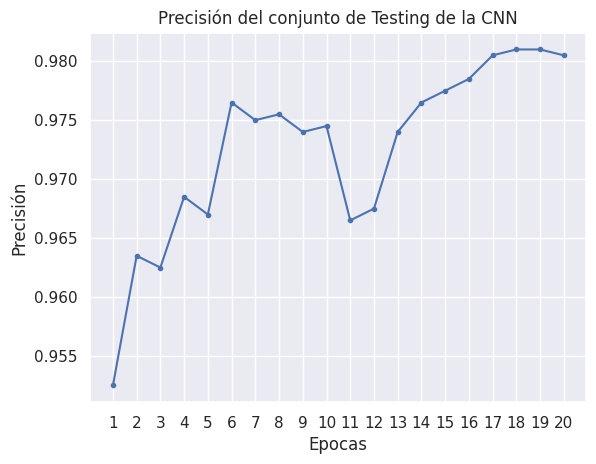

In [14]:
# Plot de la precisión respecto a las épocas
plt.plot(range(1, len(acc_count) +1 ), acc_count, marker='.')
plt.xticks(range(1, len(acc_count)+1))
plt.ylabel('Precisión')
plt.xlabel('Epocas')
plt.title('Precisión del conjunto de Testing de la CNN')
plt.show()

# Posibles preguntas

1. Grafique en un solo plot la curva de precisión para train y test.
1. Repita el experimento de entrenamiento M veces, grafique las M curvas de precisión y además la curva promedio de las M curvas.
1. Modifique los valores de learning rate (lr) del optimizador. Cómo se comportan las curvas de precisión?
1. Asuma que nuestro clasificador ahora es binario tal que responde a la pregunta f(x) = es par?. Cómo modificaría el dataset? Grafique las curvas ROC para entrenamiento y test ahora que tenemos un setup binario. Repita experimento 2) para este setup y además analice la evolución de AUC a medida que aumentamos las épocas.
1. Agregue las componentes de MaxPooling y Dropout. Para qué funcionan? Cuándo sería útil tenerlas? Pruebe distintos valores de `p` en el caso de dropout y analice resultados.